## OSM Analysis



In [1]:
!pip install osmnx

In [2]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

We start by gettin a location:

In [3]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import box
from shapely import affinity
import numpy as np

class RotatedGridGenerator:
    def __init__(self, place_name, grid_size=113, rotation_angle=-45):
        """
        place_name: str - the name of the location (e.g. "Poblenou, Barcelona, Spain")
        grid_size: int - the grid cell size in meters (width = height)
        rotation_angle: float - clockwise rotation in degrees (e.g., -45)
        """
        self.place_name = place_name
        self.grid_size = grid_size
        self.rotation_angle = rotation_angle
        self.city_boundary = self._get_boundary()
        self.crs = self.city_boundary.crs
        self.grid = self._generate_rotated_grid()

    def _get_boundary(self):
        """Download and return the city or neighborhood boundary"""
        return ox.geocode_to_gdf(self.place_name).to_crs(epsg=3857)

    def _generate_rotated_grid(self):
        """Create a rotated square grid clipped to the city boundary"""
        minx, miny, maxx, maxy = self.city_boundary.total_bounds
        cells = []
        for x in np.arange(minx, maxx, self.grid_size):
            for y in np.arange(miny, maxy, self.grid_size):
                cell = box(x, y, x + self.grid_size, y + self.grid_size)
                cells.append(cell)

        # Rotate grid around city center
        cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]
        rotated_cells = [affinity.rotate(cell, self.rotation_angle, origin=(cx, cy)) for cell in cells]

        grid = gpd.GeoDataFrame(geometry=rotated_cells, crs=self.crs)
        grid = gpd.overlay(grid, self.city_boundary, how="intersection")
        grid["cell_id"] = range(len(grid))
        return grid

    def get_grid(self):
        """Return the rotated clipped grid as a GeoDataFrame"""
        return self.grid

    def plot(self, ax=None, **kwargs):
        """Quick visualization of the grid"""
        if ax is None:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots(figsize=(10, 10))
        self.city_boundary.boundary.plot(ax=ax, edgecolor="blue")
        self.grid.plot(ax=ax, edgecolor="red", facecolor="none", **kwargs)
        ax.set_title(f"Rotated Grid on {self.place_name} (size={self.grid_size}m, angle={self.rotation_angle}°)")
        ax.set_axis_off()
        ax.set_aspect("equal")
        return ax

C:\Users\DELL\AppData\Local\Temp\ipykernel_14420\897266950.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cx, cy = self.city_boundary.geometry.unary_union.centroid.coords[0]


<Axes: title={'center': 'Rotated Grid on Poblenou, Barcelona, Spain (size=226m, angle=-45°)'}>

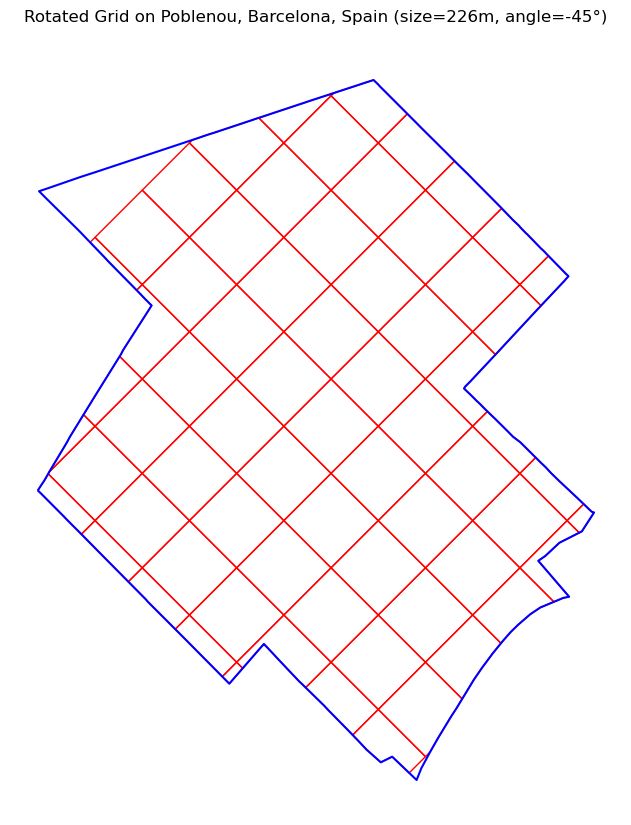

In [4]:
# Create a grid over Poblenou, with 2x2 blocks per cell (~226m), rotated 45°
gridgen = RotatedGridGenerator("Poblenou, Barcelona, Spain", grid_size=226, rotation_angle=-45)

# Get the grid as GeoDataFrame
grid = gridgen.get_grid()

# Plot it
gridgen.plot()

In [5]:
place_name = "Poblenou, Barcelona, Spain"
G = ox.graph_from_place(place_name, network_type="drive")

In [6]:
# set value to True for all values pairable to the key
# key = "amenity"
value_nomnom = {"amenity":["bar","restaurant","pub","cafe","fast_food"]}
value_couchcounty = {"amenity":["apartments", "bungalow", "detached", "annex", "dormitory", "house", "residential", "semidetached_house", "stilt_house"]}
value_HustleHub = {"amenity":["commercial", "khiosk", "office", "retail", "supermarket"]}
# value_smokestackland = {"amenity":["industrial", "warehouse"]}

# Download the Points of interest
# tags = {key: value}
tags_couch = value_couchcounty
tags_nomnom = value_nomnom
tags_HustleHub = value_HustleHub
# tags_smokestackland = value_smokestackland

#the list of spaces
couch_list = ox.features.features_from_place(place_name, tags=tags_couch)
nomnom_list = ox.features.features_from_place(place_name, tags=tags_nomnom)
HustleHub_list = ox.features.features_from_place(place_name, tags=tags_HustleHub)
# smoke_list = ox.features.features_from_place(place_name, tags=tags_smokestackland)
print(couch_list)
print(nomnom_list)
print(HustleHub_list)
# smokestackland_list

                                    geometry addr:housenumber addr:postcode  \
element id                                                                    
node    6064566288  POINT (2.20559 41.40011)               15         08005   

                            addr:street    amenity entrance               name  
element id                                                                      
node    6064566288  Carrer de l'Amistat  dormitory      yes  Associació In Via  
                                                             geometry  \
element id                                                              
node    660100527                            POINT (2.19677 41.40469)   
        660100529                            POINT (2.19419 41.40486)   
        660771772                             POINT (2.19776 41.4035)   
        660778771                             POINT (2.19865 41.4029)   
        660784487                             POINT (2.1989 41.40273)   
...     

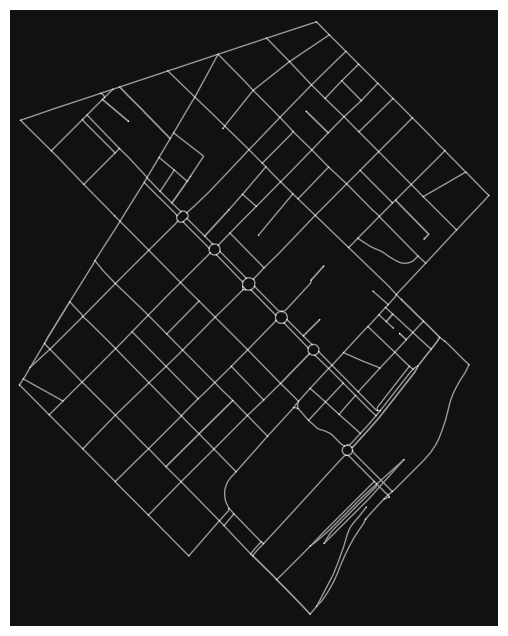

(237, 76)
(1, 7)
(1, 3)


In [7]:
ox.plot_graph(G, node_size=1)
print(nomnom_list.shape)
print(couch_list.shape)
print(HustleHub_list.shape)

In [8]:
# Filter out non-points geometry
gdf_pts = gdf.loc[gdf.geometry.geometry.type=='Point']
gdf_pts.shape
gdf_pts

NameError: name 'gdf' is not defined

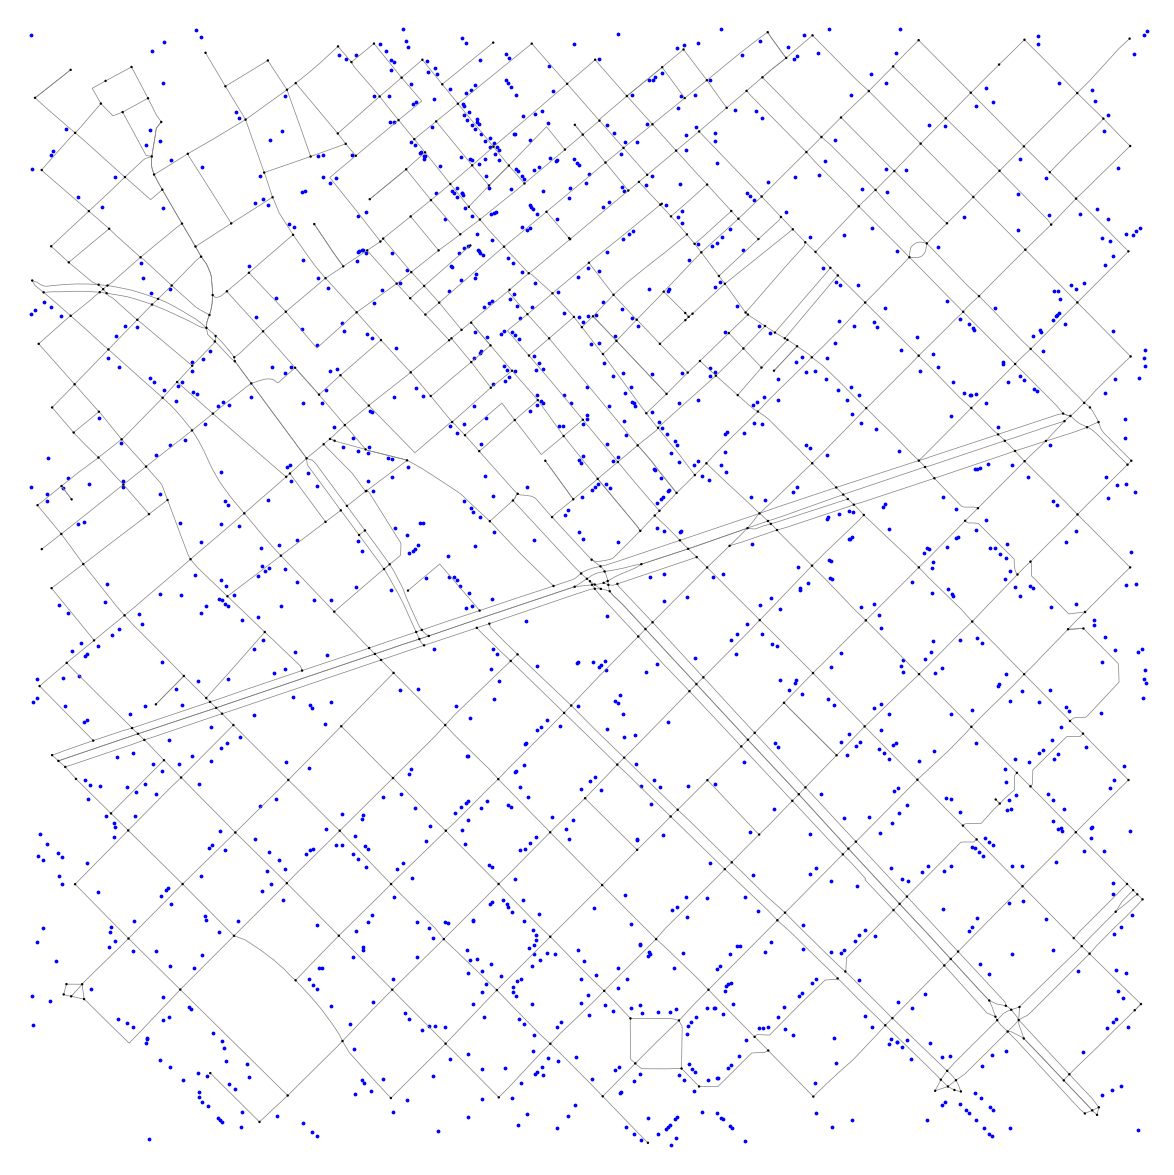

In [7]:
# Start plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot GeoDataFrame
gdf_pts.plot(ax=ax, color='blue', markersize=3)

# Draw the graph
ox.plot_graph(G, ax=ax, node_size=3, node_color= "black", edge_linewidth=0.5, edge_color='gray')

plt.show()